本章先建立一个模型生成了1000个样本数据，然后通过切割样本数据集生成一堆大小为batch_size的样本数据，然后在假设不知道数学模型的情况下，通过训练这些大
小为batch_size的样本数据集，通过初始化模型参数，建立模型，设立损失函数，通过随机梯度下降的方法设定优化算法更新模型参数，最后得出了最佳模型参数。

结论：比较发现与我们之前建立的模型中的参数相差不大，因为是在这个模型生成的数据集下进行训练的。可以对学习率和迭代次数进行修改，学习率的参数设置需要恰
当，迭代次数越多，最后得出的模型参数越好。

In [1]:
#%matplotlib inline指默认将matplotlib绘画图形放入notebook里面
%matplotlib inline
#用于随机梯度下降和初始化权重
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集。使用线性模型参数w=[2,-3.4]T ，b=4.2和噪声项C生成数据集及其标签

y=x*w+b+c

In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))  #生成一个均值为0，方差为1的随机数组，样本数量为num_examples，w列
    y = torch.matmul(X, w) + b
    c = torch.normal(0, 0.01, y.shape) #加上均值为0，方差为1，shape与y相同的随机噪音
    y = y+c
    return X, y.reshape((-1, 1)), c

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels, c= synthetic_data(true_w, true_b, 1000)     #生成特征/x和标签/y

In [3]:
len(features)

1000

In [4]:
#打印出第0个样本的特征和标签以及附加噪音值
print('features:',features[0],'\nlabel:', labels[0] ,'\nc:', c[0])

features: tensor([1.0199, 0.7038]) 
label: tensor([3.8565]) 
c: tensor(0.0095)


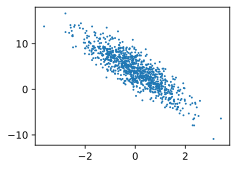

In [5]:
d2l.set_figsize()
#d2l.plt.scatter(特征第1列，标签，散点大小为1)    ，得出结论特征第一列与标签负相关
d2l.plt.scatter(features[:,(1)].detach().numpy(),   labels.detach().numpy(), 1)     #绘制特征和标签的散点图


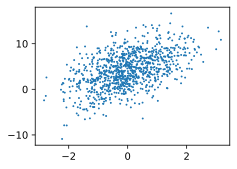

In [6]:
#d2l.plt.scatter(特征第0列，标签，散点大小为1)    ，得出结论特征第0列与标签正相关
d2l.plt.scatter(features[:,(0)].detach().numpy(),   labels.detach().numpy(), 1)     #绘制特征和标签的散点图

定义一个data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。 每个小批量包含一组特征和标签。

In [7]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))     #建立样本的索引
    random.shuffle(indices)     # 这些样本是随机读取的，没有特定的顺序。即打乱样本的索引值
    for i in range(0, num_examples, batch_size):        #从0遍历到num_examples,步长为batch_size
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])      #每次循环都会生成一个大小为batch_sized的小批量数据集
        yield features[batch_indices], labels[batch_indices]    #yield相当于循环中的return，每次循环都会返回特征和标签

In [8]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break       #break跳出只循环一次，若没有break，将会循环100次后结束（features长度为1000，步长为10）

tensor([[ 0.7572,  0.0283],
        [ 0.1817,  0.3024],
        [-1.1053, -0.0302],
        [ 1.0922,  0.2791],
        [ 0.0786,  0.6209],
        [-1.2080,  0.4948],
        [ 0.0110,  0.1992],
        [ 0.9777,  0.6671],
        [ 1.0413,  0.6860],
        [ 0.1280, -1.4311]]) 
 tensor([[5.6260],
        [3.5409],
        [2.1019],
        [5.4353],
        [2.2530],
        [0.1089],
        [3.5501],
        [3.8853],
        [3.9475],
        [9.3164]])


In [9]:
#初始化模型参数
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)  #均值为0，方差为0.01的正太分布，矩阵为两行一列，w需要更新故设置requires_grad=True
b = torch.zeros(1, requires_grad=True)     #偏差b初始值设置为，因b同样需要更新故设置requires_grad=True

In [10]:
#定义模型  y=x*w+b
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [11]:
#定义损失函数  y_hat为预测值，y为真实值  loss=0.5*(预测-真实)²
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2    #reshape是统一预测和真是的形状

In [12]:
#定义优化算法(随机梯度下降)  param是一个包含所有参数的list这里包含w,b  ，lr为学习率，batch_size为批量大小
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():   #不采用梯度计算
        for param in params:
            param -= lr * param.grad / batch_size  
#param(t) = [param(t-1)-lr*(loss对param求导)]/batch_size，即更新参数，这里除以批量大小是为了取平均值（前面定义损失函数没有取平均所以这里取）
            param.grad.zero_() #每次计算后将梯度设置为0，防止对下一次计算产生影响

In [13]:
#训练过程
lr = 0.03   
num_epochs = 3  #指对整个训练集扫描三遍
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失       
        l.sum().backward()  # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，并以此计算关于[w,b]的梯度
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数  这里除以batch_size可以理解为前面l是batch_size个loss相加
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.040076
epoch 2, loss 0.000151
epoch 3, loss 0.000051


In [14]:
print(w.reshape(true_w.shape),b)   #打印训练后得到的最佳参数w,b
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

tensor([ 1.9997, -3.3989], grad_fn=<ReshapeAliasBackward0>) tensor([4.1996], requires_grad=True)
w的估计误差: tensor([ 0.0003, -0.0011], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0004], grad_fn=<RsubBackward1>)


因为我们使用的是自己合成的数据集，所以我们知道真正的参数是什么。 因此，我们可以通过比较真实参数和通过训练学到的参数来评估训练的成功程度。 事实上，真实参数和通过训练学到的参数确实非常接近。